# Hudson and Thames Skill Set Challenge

Author: [@mirca](https://www.github.com/mirca)

## Introduction

In this notebook, we are going to see how to programmatically access stocks price data and
construct a minimum spanning tree (MST) graph based on those data. The MST graph will reveal
stocks dependencies which can be further leveraged into tasks such as hierachical risk parity portfolio.

In [1]:
import numpy as np
import pandas_datareader as pdr
import requests
import bs4 as bs
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from core import compute_adjacency_mst_and_distances

## Accessing financial data from Yahoo! finance

In this step we are going to download stocks prices data from Yahoo! finance.
For that, I chose to pick the 50 most representative stocks of the S&P 500 index.

The following lines of code web scrapes the website https://www.slickcharts.com/sp500 and gets the 50 most representative stocks
of the S&P 500 index:

In [2]:
resp = requests.get('https://www.slickcharts.com/sp500')
soup = bs.BeautifulSoup(resp.text, 'html.parser')
table = soup.find('table', {'class': 'table table-hover table-borderless table-sm'})
stocks = [fn['href'][len("/symbol/"):] for fn in table.find_all('a') if fn['href'].startswith('/symbol')]
stocks_ = [stocks[i] for i in range(len(stocks)) if i % 2 == 0][:50]

In [3]:
print(stocks_)

['MSFT', 'AAPL', 'AMZN', 'FB', 'BRK.B', 'GOOG', 'GOOGL', 'JNJ', 'JPM', 'V', 'PG', 'T', 'UNH', 'MA', 'HD', 'INTC', 'VZ', 'KO', 'BAC', 'XOM', 'MRK', 'DIS', 'PFE', 'PEP', 'CMCSA', 'CVX', 'ADBE', 'CSCO', 'NVDA', 'WMT', 'NFLX', 'CRM', 'WFC', 'MCD', 'ABT', 'BMY', 'COST', 'BA', 'C', 'PM', 'NEE', 'MDT', 'ABBV', 'PYPL', 'AMGN', 'TMO', 'LLY', 'HON', 'ACN', 'IBM']


Now that we have the ticker names, let's download the price data from Yahoo! finance:

In [4]:
prices = pdr.get_data_yahoo(stocks_, start = "2018-12-31", end = "2019-12-31")[['Adj Close']]

/Users/mirca/opt/miniconda3/lib/python3.7/site-packages/pandas_datareader/base.py:270: SymbolWarning: Failed to read symbol: 'BRK.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


Let's drop any stocks that have missing values and let's also clean up the attributes of our data frame:

In [5]:
prices.dropna(axis='columns', inplace=True)
prices.columns = prices.columns.droplevel(0)

Now we can compute the log returns of the stocks:

In [6]:
log_returns = prices.apply(np.log).apply(np.diff)

In [7]:
log_returns.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOG,GOOGL,JNJ,JPM,V,PG,...,NEE,MDT,ABBV,PYPL,AMGN,TMO,LLY,HON,ACN,IBM
0,-0.004440,0.001140,0.024440,0.034415,0.009839,0.009259,-0.010125,0.017164,0.007400,-0.006987,...,-0.023222,-0.033993,-0.032635,0.019548,-0.014332,-0.019720,-0.007285,-0.002197,-0.002983,0.013457
1,-0.037482,-0.104924,-0.025566,-0.029469,-0.028898,-0.028086,-0.016018,-0.014314,-0.036702,-0.007036,...,-0.002476,-0.028496,-0.033504,-0.043620,-0.015333,-0.033600,-0.031569,-0.013441,-0.034738,-0.020165
2,0.045460,0.041803,0.048851,0.046061,0.052390,0.050021,0.016644,0.036202,0.042179,0.020205,...,0.018249,0.030882,0.031709,0.049666,0.033612,0.044208,0.029652,0.034383,0.038147,0.038314
3,0.001275,-0.002228,0.033776,0.000725,-0.002169,-0.001996,-0.006435,0.000695,0.017871,-0.004008,...,-0.001450,-0.066621,0.014490,0.007621,0.013367,0.013393,0.005393,0.005556,0.003467,0.007050
4,0.007225,0.018884,0.016476,0.031937,0.007358,0.008745,0.022961,-0.001887,0.005424,0.003684,...,0.007287,0.007010,0.004637,0.020157,0.012742,0.023004,0.009153,-0.002071,0.024975,0.014119


In next line we are going to compute the [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) of a minimum spanning tree graph
and the corresponding distances between each pair of stocks:

In [8]:
distances, adjacency = compute_adjacency_mst_and_distances(log_returns)
adjacency_df = pd.DataFrame(adjacency, columns=prices.columns, index=prices.columns)

## Visualizations of the MST (adjacency matrix and graph)

Now let's visualize the adjacency matrix of our tree graph and the graph itself:

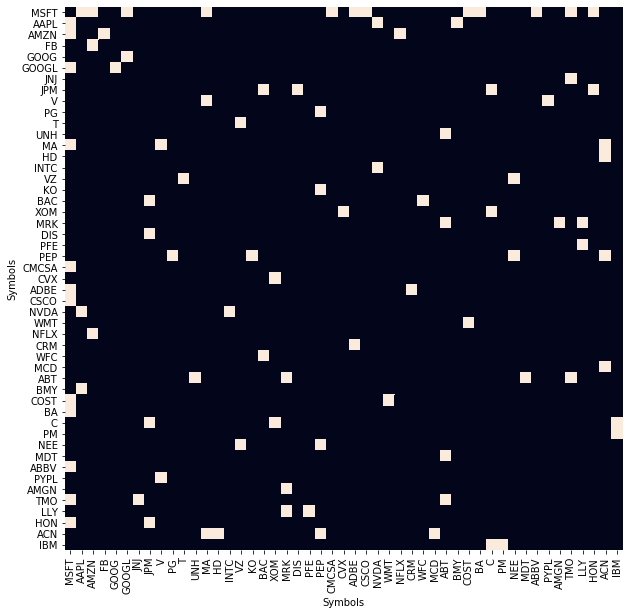

In [9]:
plt.figure(figsize=(10, 10))
g = sns.heatmap(adjacency_df, cbar=False)
plt.show()

The adjacency matrix tell us which stocks are conditionally dependent in the graph. In the plot
above, the white squares represent pairs of stocks that are dependent and therefore have an edge between them.

Now, let's plot the network itself so that we can recognize its tree structure:

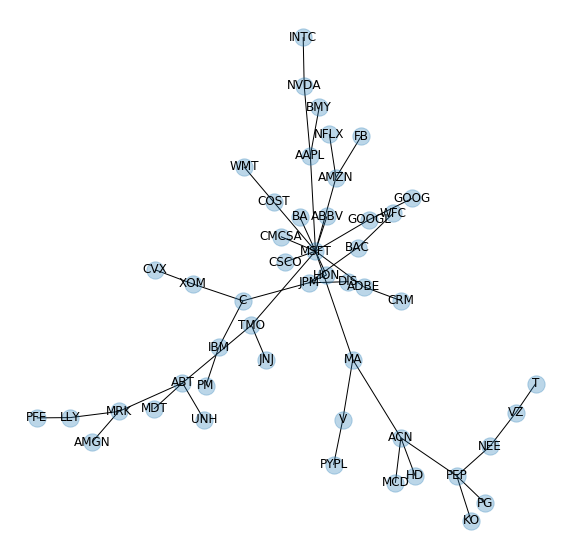

In [10]:
labels = {v: k for v, k in enumerate(list(adjacency_df.columns))}
plt.figure(figsize=(10, 10))
G = nx.from_numpy_matrix(adjacency)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300, alpha=.3)
nx.draw_networkx_edges(G, pos, width=1.0)
_ = nx.draw_networkx_labels(G, pos, labels)
_ = plt.axis('off')

From the plot above is easier to see some clusters structures, e.g., formed by the tech companies Facebook (FB), Netflix (NFLX), Amazon (AMZN), and Microsoft (MSFT), or pharmaceutical corporations Pfizer (PFE), Eli Lilly and Company (LLY), UnitedHealth Group (UNH), and Merck & Co (MRK).

Let's also draw a dendrogram from the distance matrix: 

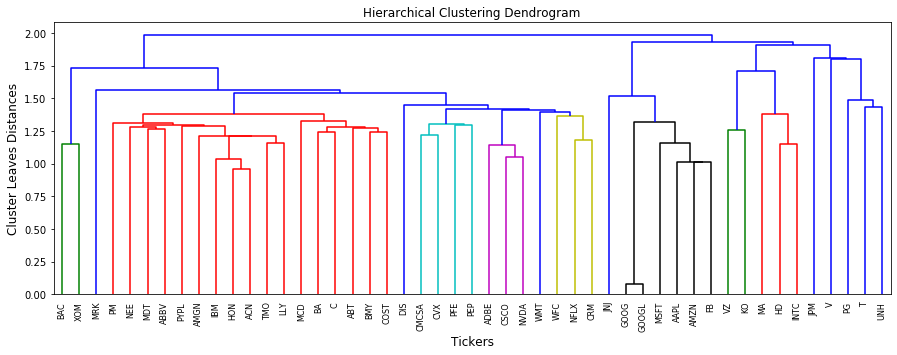

In [11]:
clusters = linkage(np.triu(distances, k=1))
plt.figure(figsize=(15, 5))
dendrogram(clusters, labels=adjacency_df.columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Cluster Leaves Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=12)
plt.show()

## Conclusion

In this notebook we saw how to construct a minimum spanning tree graph from a set of stocks prices. The MST
may be used to reveal the hierarchical structure of a set stocks via their conditional dependency, which is
directly encoded on the edges of the graph.